Example 1: Simple U-238 decay chain
--------------------------------------------------
Initial U-238: 1.00e+06 atoms
Final U-238: 1.00e+06 atoms
Final Th-234: 1.53e-04 atoms
Final Pa-234m: 1.28e-09 atoms
Final U-234: 2.21e-06 atoms


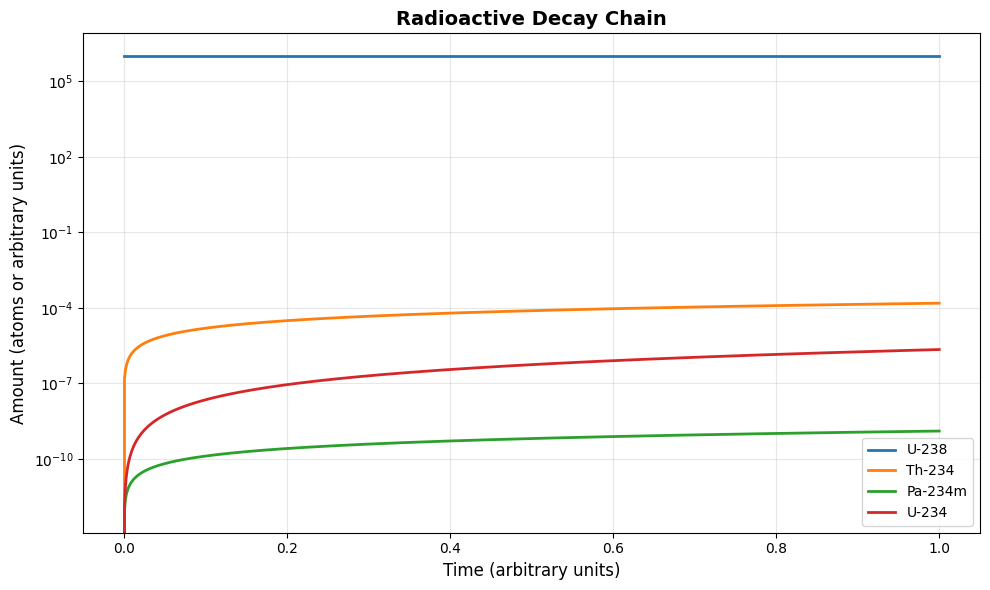


Example 2: Branching decay
--------------------------------------------------


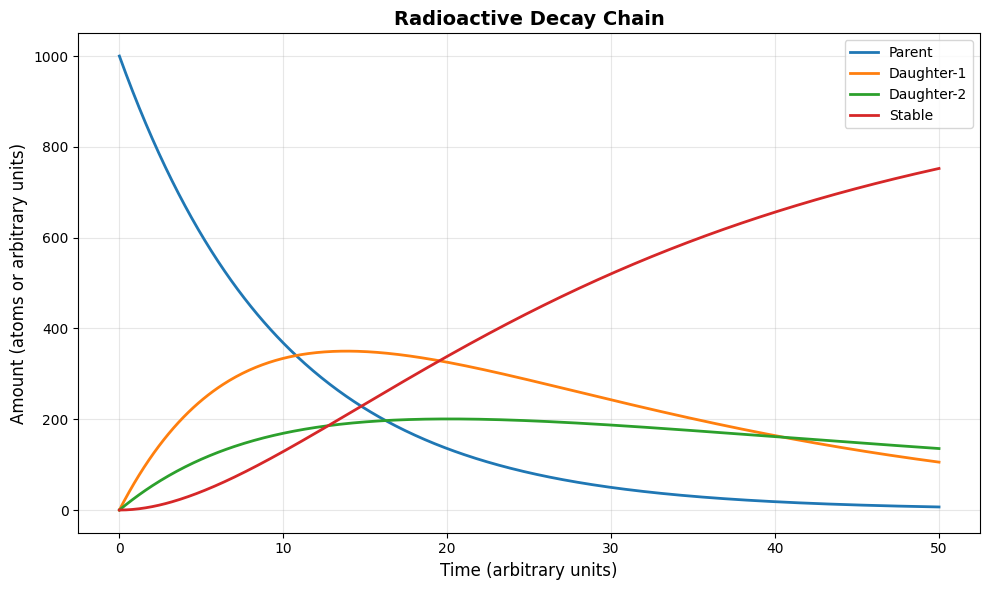


Example 3: Secular equilibrium
--------------------------------------------------
At equilibrium (t=20.00):
Parent activity: 1.00e+04
Daughter activity: 1.00e+04
Ratio: 1.0000


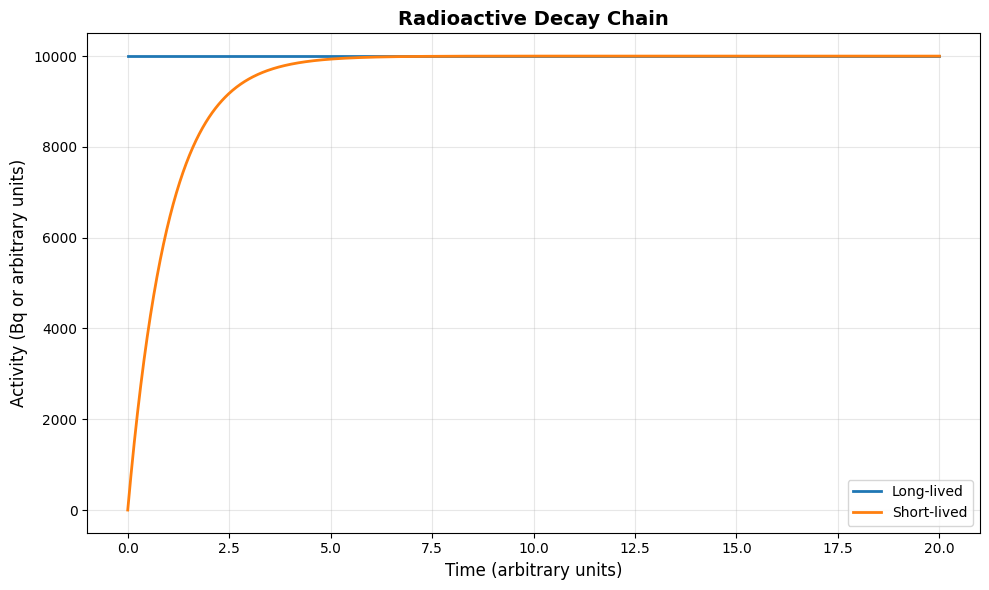


Bateman Equation Solver - Ready to use!


In [4]:
"""
Bateman Equation Solver for Nuclear Decay Chains
Solves complex radioactive decay chains using the Bateman equations


Author: Adrita Khan
Date: 30.11.2025
"""

import numpy as np
from scipy.integrate import odeint
from scipy.linalg import expm
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple, Optional
import warnings

class NuclideData:
    """Represents a single nuclide in the decay chain"""
    
    def __init__(self, name: str, decay_constant: float, initial_amount: float = 0.0):
        """
        Parameters:
        -----------
        name : str
            Name/symbol of the nuclide
        decay_constant : float
            Decay constant (1/time unit)
        initial_amount : float
            Initial amount/activity at t=0
        """
        self.name = name
        self.decay_constant = decay_constant
        self.half_life = np.log(2) / decay_constant if decay_constant > 0 else np.inf
        self.initial_amount = initial_amount

class DecayChain:
    """Represents a complete radioactive decay chain"""
    
    def __init__(self):
        self.nuclides: List[NuclideData] = []
        self.transitions: List[Tuple[int, int, float]] = []  # (from_idx, to_idx, branching_ratio)
        self.nuclide_map: Dict[str, int] = {}
    
    def add_nuclide(self, name: str, decay_constant: float, initial_amount: float = 0.0):
        """Add a nuclide to the decay chain"""
        if name in self.nuclide_map:
            raise ValueError(f"Nuclide {name} already exists in chain")
        
        idx = len(self.nuclides)
        self.nuclide_map[name] = idx
        nuclide = NuclideData(name, decay_constant, initial_amount)
        self.nuclides.append(nuclide)
        return idx
    
    def add_decay(self, parent: str, daughter: str, branching_ratio: float = 1.0):
        """
        Add a decay transition from parent to daughter
        
        Parameters:
        -----------
        parent : str
            Name of parent nuclide
        daughter : str
            Name of daughter nuclide
        branching_ratio : float
            Branching ratio (0-1), default 1.0 for single decay mode
        """
        if parent not in self.nuclide_map:
            raise ValueError(f"Parent nuclide {parent} not found")
        if daughter not in self.nuclide_map:
            raise ValueError(f"Daughter nuclide {daughter} not found")
        
        parent_idx = self.nuclide_map[parent]
        daughter_idx = self.nuclide_map[daughter]
        
        if branching_ratio <= 0 or branching_ratio > 1:
            raise ValueError("Branching ratio must be between 0 and 1")
        
        self.transitions.append((parent_idx, daughter_idx, branching_ratio))
    
    def get_decay_matrix(self) -> np.ndarray:
        """
        Construct the decay matrix A for the system dN/dt = A*N
        """
        n = len(self.nuclides)
        A = np.zeros((n, n))
        
        # Diagonal elements: -lambda_i (loss by decay)
        for i, nuclide in enumerate(self.nuclides):
            A[i, i] = -nuclide.decay_constant
        
        # Off-diagonal elements: lambda_j * BR_ji (gain from parent decay)
        for parent_idx, daughter_idx, br in self.transitions:
            lambda_parent = self.nuclides[parent_idx].decay_constant
            A[daughter_idx, parent_idx] += lambda_parent * br
        
        return A
    
    def get_initial_vector(self) -> np.ndarray:
        """Get initial amounts vector"""
        return np.array([n.initial_amount for n in self.nuclides])

class BatemanSolver:
    """Solver for Bateman equations using multiple methods"""
    
    def __init__(self, decay_chain: DecayChain):
        self.chain = decay_chain
        self.A = decay_chain.get_decay_matrix()
        self.N0 = decay_chain.get_initial_vector()
    
    def solve_matrix_exponential(self, t: np.ndarray) -> np.ndarray:
        """
        Solve using matrix exponential method: N(t) = exp(A*t) * N0
        Most accurate for short to medium chains
        """
        results = np.zeros((len(t), len(self.N0)))
        
        for i, time in enumerate(t):
            results[i] = expm(self.A * time) @ self.N0
        
        return results
    
    def solve_ode(self, t: np.ndarray) -> np.ndarray:
        """
        Solve using ODE integration (adaptive step size)
        Good for stiff systems and long chains
        """
        def derivative(N, t):
            return self.A @ N
        
        results = odeint(derivative, self.N0, t)
        return results
    
    def solve_analytical(self, t: np.ndarray) -> np.ndarray:
        """
        Analytical solution for simple linear chains (no branching)
        Very fast for simple chains
        """
        # Check if chain is linear (each nuclide has at most one parent)
        parent_count = [0] * len(self.chain.nuclides)
        for parent_idx, daughter_idx, _ in self.chain.transitions:
            parent_count[daughter_idx] += 1
        
        if max(parent_count) > 1:
            raise ValueError("Analytical solution only works for linear chains (no branching)")
        
        n = len(self.chain.nuclides)
        lambdas = np.array([nuc.decay_constant for nuc in self.chain.nuclides])
        
        results = np.zeros((len(t), n))
        
        for tidx, time in enumerate(t):
            # First nuclide (parent)
            results[tidx, 0] = self.N0[0] * np.exp(-lambdas[0] * time)
            
            # Subsequent nuclides
            for i in range(1, n):
                if self.N0[i] > 0:
                    results[tidx, i] += self.N0[i] * np.exp(-lambdas[i] * time)
                
                # Find parent
                parent_idx = None
                for p, d, _ in self.chain.transitions:
                    if d == i:
                        parent_idx = p
                        break
                
                if parent_idx is not None and self.N0[parent_idx] > 0:
                    # Bateman equation for linear chain
                    sum_terms = 0.0
                    for j in range(parent_idx, i + 1):
                        prod = 1.0
                        for k in range(parent_idx, j):
                            prod *= lambdas[k]
                        
                        denom = 1.0
                        for k in range(parent_idx, i + 1):
                            if k != j:
                                denom *= (lambdas[k] - lambdas[j])
                        
                        if abs(denom) > 1e-15:
                            sum_terms += (prod / denom) * np.exp(-lambdas[j] * time)
                    
                    results[tidx, i] += self.N0[parent_idx] * sum_terms
        
        return results
    
    def solve(self, t: np.ndarray, method: str = 'auto') -> np.ndarray:
        """
        Solve the decay chain
        
        Parameters:
        -----------
        t : np.ndarray
            Time points to evaluate
        method : str
            'auto', 'matrix_exp', 'ode', or 'analytical'
        
        Returns:
        --------
        np.ndarray
            Array of shape (len(t), n_nuclides) with amounts at each time
        """
        if method == 'auto':
            # Choose method based on chain characteristics
            n = len(self.chain.nuclides)
            if n <= 10:
                method = 'matrix_exp'
            else:
                method = 'ode'
        
        if method == 'matrix_exp':
            return self.solve_matrix_exponential(t)
        elif method == 'ode':
            return self.solve_ode(t)
        elif method == 'analytical':
            return self.solve_analytical(t)
        else:
            raise ValueError(f"Unknown method: {method}")
    
    def get_activities(self, amounts: np.ndarray) -> np.ndarray:
        """Convert amounts to activities: A = lambda * N"""
        lambdas = np.array([n.decay_constant for n in self.chain.nuclides])
        return amounts * lambdas[np.newaxis, :]
    
    def plot_results(self, t: np.ndarray, amounts: np.ndarray, 
                     plot_type: str = 'amounts', log_scale: bool = True,
                     filename: Optional[str] = None):
        """
        Plot the decay chain results
        
        Parameters:
        -----------
        t : np.ndarray
            Time points
        amounts : np.ndarray
            Amounts array from solve()
        plot_type : str
            'amounts' or 'activities'
        log_scale : bool
            Use logarithmic y-axis
        filename : str
            If provided, save plot to file
        """
        plt.figure(figsize=(10, 6))
        
        if plot_type == 'activities':
            data = self.get_activities(amounts)
            ylabel = 'Activity (Bq or arbitrary units)'
        else:
            data = amounts
            ylabel = 'Amount (atoms or arbitrary units)'
        
        for i, nuclide in enumerate(self.chain.nuclides):
            plt.plot(t, data[:, i], label=nuclide.name, linewidth=2)
        
        plt.xlabel('Time (arbitrary units)', fontsize=12)
        plt.ylabel(ylabel, fontsize=12)
        plt.title('Radioactive Decay Chain', fontsize=14, fontweight='bold')
        plt.legend(loc='best')
        plt.grid(True, alpha=0.3)
        
        if log_scale:
            plt.yscale('log')
        
        plt.tight_layout()
        
        if filename:
            plt.savefig(filename, dpi=300, bbox_inches='tight')
        
        plt.show()


# Example usage and test cases
def example_simple_chain():
    """Example: Simple U-238 decay chain (first few steps)"""
    print("Example 1: Simple U-238 decay chain")
    print("-" * 50)
    
    chain = DecayChain()
    
    # U-238 -> Th-234 -> Pa-234m -> U-234
    # Using simplified decay constants (1/years)
    chain.add_nuclide("U-238", 1.551e-10, initial_amount=1e6)  # T1/2 = 4.468e9 years
    chain.add_nuclide("Th-234", 2.876e-2, initial_amount=0)    # T1/2 = 24.1 days
    chain.add_nuclide("Pa-234m", 3.434e3, initial_amount=0)    # T1/2 = 1.17 min
    chain.add_nuclide("U-234", 2.826e-6, initial_amount=0)     # T1/2 = 245,500 years
    
    chain.add_decay("U-238", "Th-234")
    chain.add_decay("Th-234", "Pa-234m")
    chain.add_decay("Pa-234m", "U-234")
    
    solver = BatemanSolver(chain)
    
    # Solve over 1 year
    t = np.linspace(0, 1, 1000)  # 1 year
    amounts = solver.solve(t, method='matrix_exp')
    
    print(f"Initial U-238: {amounts[0, 0]:.2e} atoms")
    print(f"Final U-238: {amounts[-1, 0]:.2e} atoms")
    print(f"Final Th-234: {amounts[-1, 1]:.2e} atoms")
    print(f"Final Pa-234m: {amounts[-1, 2]:.2e} atoms")
    print(f"Final U-234: {amounts[-1, 3]:.2e} atoms")
    
    solver.plot_results(t, amounts, plot_type='amounts', log_scale=True)
    
    return chain, solver, t, amounts


def example_branching_decay():
    """Example: Decay chain with branching"""
    print("\nExample 2: Branching decay")
    print("-" * 50)
    
    chain = DecayChain()
    
    # Parent decays to two daughters with different branching ratios
    chain.add_nuclide("Parent", 0.1, initial_amount=1000)
    chain.add_nuclide("Daughter-1", 0.05, initial_amount=0)
    chain.add_nuclide("Daughter-2", 0.02, initial_amount=0)
    chain.add_nuclide("Stable", 0.0, initial_amount=0)
    
    chain.add_decay("Parent", "Daughter-1", branching_ratio=0.7)
    chain.add_decay("Parent", "Daughter-2", branching_ratio=0.3)
    chain.add_decay("Daughter-1", "Stable")
    chain.add_decay("Daughter-2", "Stable")
    
    solver = BatemanSolver(chain)
    
    t = np.linspace(0, 50, 500)
    amounts = solver.solve(t, method='matrix_exp')
    
    solver.plot_results(t, amounts, plot_type='amounts', log_scale=False)
    
    return chain, solver, t, amounts


def example_secular_equilibrium():
    """Example: Secular equilibrium"""
    print("\nExample 3: Secular equilibrium")
    print("-" * 50)
    
    chain = DecayChain()
    
    # Long-lived parent with short-lived daughter
    chain.add_nuclide("Long-lived", 1e-5, initial_amount=1e9)
    chain.add_nuclide("Short-lived", 1.0, initial_amount=0)
    
    chain.add_decay("Long-lived", "Short-lived")
    
    solver = BatemanSolver(chain)
    
    t = np.linspace(0, 20, 1000)
    amounts = solver.solve(t, method='matrix_exp')
    activities = solver.get_activities(amounts)
    
    print(f"At equilibrium (t={t[-1]:.2f}):")
    print(f"Parent activity: {activities[-1, 0]:.2e}")
    print(f"Daughter activity: {activities[-1, 1]:.2e}")
    print(f"Ratio: {activities[-1, 1] / activities[-1, 0]:.4f}")
    
    solver.plot_results(t, amounts, plot_type='activities', log_scale=False)
    
    return chain, solver, t, amounts


if __name__ == "__main__":
    # Run examples
    example_simple_chain()
    example_branching_decay()
    example_secular_equilibrium()
    
    print("\n" + "=" * 50)
    print("Bateman Equation Solver - Ready to use!")
    print("=" * 50)